# Giới thiệu 

Phân tích tình cảm đề cập đến việc xác định cũng như phân loại các tình cảm được thể hiện trong nguồn văn bản. Tweets thường hữu ích trong việc tạo ra một lượng lớn dữ liệu tình cảm khi phân tích. Những dữ liệu này rất hữu ích trong việc hiểu ý kiến của mọi người về nhiều chủ đề khác nhau.

Do đó, chúng tôi cần phát triển Mô hình phân tích tình cảm học máy tự động để tính toán nhận thức của khách hàng. Do sự hiện diện của các ký tự không hữu ích (collectively termed as the noise) cùng với dữ liệu hữu ích.

Mục đích của tôi là phân tích cảm xúc của các tweet được cung cấp từ bộ dữ liệu bằng cách phát triển một quy trình học máy liên quan đến việc sử dụng ba bộ phân loại (Hồi quy logistic, Bernoulli Naive Bayes và RandomForest) cùng với việc sử dụng Term Frequency- Inverse Document Frequency (TF-IDF ). 

# Problem Statement

Trong dự án này, tôi cố gắng triển khai mô hình phân tích tình cảm Twitter giúp vượt qua những thách thức trong việc xác định tình cảm của các tweet.

Các đặc tính liên quan đến tập dữ liệu là:

1. ids: ID mỗi Tweets

2. date: Thời gian đăng bình luận

3. flag: Nó đề cập đến truy vấn. Nếu không có truy vấn nào như vậy tồn tại thì không có câu hỏi.

4. user: Tên user đăng bình luận

5. text: Nội dung bình luận

6. Sentiment: Gán nhãn mỗi tweet

# Project Pipeline

Các bước thực hiện:

1. Import các thư viện cần thiết

2. Đọc và ghi tập dữ liệu 

3. Thông tin và kiểu dữ liệu

4. Trực quan hóa 

5. Tiền xử lí dữ liệu

6. Tách dữ liệu thành tập train, test

7. Chuyển đổi dữ liệu bằng TF-IDF Vectorizer

8. Xây dựng mô hình 

Kết luận

# Import Necessary Dependencies

In [25]:
# !pip install wordcloud
# !pip install seaborn
# !pip install sklearn
# !pip install nltk

In [26]:
import re
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer


import time

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Read and Load the Dataset

In [27]:
# Importing the dataset
df = pd.read_csv('https://raw.githubusercontent.com/namhai03/Twitter_Sentiment_Analysis/main/twitter.csv', encoding= "ISO-8859-1")

# Exploratory Data Analysis 

3.1: Five top records of data

In [28]:
df.head()

,ids,date,flag,user,text,Sentiment
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Positive
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Neutral
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Positive
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Positive
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Negative


3.2: Columns/features in data

In [29]:
df.columns

Index(['ids', 'date', 'flag', 'user', 'text', 'Sentiment'], dtype='object')

3.3: Length of the dataset

In [30]:
print('Độ lớn của dataset:', len(df), "dòng")

Độ lớn của dataset: 20000 dòng


3.4: Shape of data

In [31]:
df. shape

(20000, 6)

3.5: Data information

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ids        20000 non-null  int64 
 1   date       20000 non-null  object
 2   flag       20000 non-null  object
 3   user       20000 non-null  object
 4   text       20000 non-null  object
 5   Sentiment  20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


3.6: Datatypes of all columns

In [33]:
df.dtypes

ids           int64
date         object
flag         object
user         object
text         object
Sentiment    object
dtype: object

3.7: Checking for Null values

In [34]:
np.sum(df.isnull().any(axis=1))  #Đếm tổng số cột có giá trị null

0

3.8: Rows and columns in the dataset

In [35]:
print('Số cột: ', len(df.columns))
print('Số dòng:', len(df))

Số cột:  6
Số dòng: 20000


# Data Preprocessing 

Trong bài toán được đưa ra ở trên, trước khi huấn luyện mô hình, tôi đã thực hiện một số bước tiền xử lý trên tập dữ liệu, chủ yếu liên quan đến việc loại bỏ stopword (từ dừng), loại bỏ emojis (biểu tượng cảm xúc). Sau đó, văn bản được chuyển đổi thành chữ thường để tăng tính tổng quát hóa.

Tiếp theo, dấu câu được làm sạch và loại bỏ, giúp giảm bớt các nhiễu không cần thiết trong tập dữ liệu. Sau đó, chúng tôi cũng loại bỏ các ký tự lặp lại trong từ cũng như loại bỏ các URL vì chúng không có ý nghĩa quan trọng.

Cuối cùng, chúng tôi đã thực hiện Stemming (giảm từ xuống dạng gốc của chúng) và Lemmatization (giảm các từ xuống dạng gốc gọi là "lemma") để đạt được kết quả tốt hơn.

4.1: Selecting the text and Target column for our further analysis

In [36]:
data=df[['text','Sentiment']]
data

,text,Sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Positive
1,is upset that he can't update his Facebook by ...,Neutral
2,@Kenichan I dived many times for the ball. Man...,Positive
3,my whole body feels itchy and like its on fire,Positive
4,"@nationwideclass no, it's not behaving at all....",Negative
...,...,...
19995,Just woke up. Having no school is the best fee...,Positive
19996,TheWDB.com - Very cool to hear old Walt interv...,Positive
19997,Are you ready for your MoJo Makeover? Ask me f...,Positive
19998,Happy 38th Birthday to my boo of alll time!!! ...,Positive


4.2: Recode Sentiment

In [37]:
def recode(text):
    if text == "Positive": return 1 
    elif text == "Neutral": return 0
    else: return -1
data["Sentiment"] = data["Sentiment"].apply(lambda text: recode(text))
data.Sentiment.dtype


C:\Users\haina\AppData\Local\Temp/ipykernel_7612/982060764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Sentiment"] = data["Sentiment"].apply(lambda text: recode(text))


dtype('int64')

4.3: Print unique values of target variables

In [38]:
data['Sentiment'].unique()

array([ 1,  0, -1], dtype=int64)

4.4: Making statement text in lower case

In [39]:
data['text']=data['text'].str.lower()
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/671079150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text']=data['text'].str.lower()


0        @switchfoot http://twitpic.com/2y1zl - awww, t...
1        is upset that he can't update his facebook by ...
2        @kenichan i dived many times for the ball. man...
3          my whole body feels itchy and like its on fire 
4        @nationwideclass no, it's not behaving at all....
                               ...                        
19995    just woke up. having no school is the best fee...
19996    thewdb.com - very cool to hear old walt interv...
19997    are you ready for your mojo makeover? ask me f...
19998    happy 38th birthday to my boo of alll time!!! ...
19999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 20000, dtype: object

4.5: Cleaning and removing URL’s

In [40]:
def cleaning_URLs(data):
    data = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data) # Xóa các URLs
    data = re.sub('@\S+', ' ', data) # Xóa cụm từ sau kí tự "@"
    return data
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/1734722343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))


0           s a bummer.  you shoulda got david carr of ...
1        is upset that he can't update his facebook by ...
2          i dived many times for the ball. managed to ...
3          my whole body feels itchy and like its on fire 
4          no, it's not behaving at all. i'm mad. why a...
                               ...                        
19995    just woke up. having no school is the best fee...
19996    thewdb.com - very cool to hear old walt interv...
19997    are you ready for your mojo makeover? ask me f...
19998    happy 38th birthday to my boo of alll time!!! ...
19999                         happy #charitytuesday       
Name: text, Length: 20000, dtype: object

4.6: Cleaning and removing punctuations

In [41]:
import string
english_punctuations = string.punctuation   # Kí tự đặc biệt
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    for i in punctuations_list:
        text = text.replace(i, "")
    return text
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/704957818.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))


0           s a bummer  you shoulda got david carr of t...
1        is upset that he cant update his facebook by t...
2          i dived many times for the ball managed to s...
3          my whole body feels itchy and like its on fire 
4          no its not behaving at all im mad why am i h...
                               ...                        
19995    just woke up having no school is the best feel...
19996    thewdbcom  very cool to hear old walt intervie...
19997    are you ready for your mojo makeover ask me fo...
19998    happy 38th birthday to my boo of alll time tup...
19999                          happy charitytuesday       
Name: text, Length: 20000, dtype: object

4.7: Cleaning and removing Numeric numbers

In [42]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/1966440224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))


0           s a bummer  you shoulda got david carr of t...
1        is upset that he cant update his facebook by t...
2          i dived many times for the ball managed to s...
3          my whole body feels itchy and like its on fire 
4          no its not behaving at all im mad why am i h...
                               ...                        
19995    just woke up having no school is the best feel...
19996    thewdbcom  very cool to hear old walt intervie...
19997    are you ready for your mojo makeover ask me fo...
19998    happy th birthday to my boo of alll time tupac...
19999                          happy charitytuesday       
Name: text, Length: 20000, dtype: object

4.8: Cleaning and removing the above stop words list from the tweet text

In [43]:
nltk.download("stopwords")
list_stopwords = set(stopwords.words("english"))
print(list_stopwords)

{'these', 'but', 'on', 'having', 'him', "mustn't", 'below', 'weren', 'been', 'did', "shouldn't", 'own', 'they', 'needn', 'as', 'until', 're', 'she', 'herself', 'ain', 'from', "you'll", "you've", 'before', 'don', 'had', 'haven', 'which', 'any', "should've", 'during', 'our', 'no', 'not', "it's", 'has', "needn't", 'some', 'and', 'were', 'against', 'with', 'myself', 'out', 'was', "don't", 'of', 'hadn', 'or', 'the', 'i', 'm', 'shouldn', 'doesn', 'for', 'her', 'a', 've', 'can', 'hasn', 'about', 'at', 'up', 'how', "aren't", 'each', 'that', "wouldn't", 'wasn', "wasn't", 'being', "you'd", 'few', 'isn', 'won', 'wouldn', 'y', 'too', "you're", "that'll", 'didn', 'through', 'ma', 'should', 'my', 'whom', 'yourself', "she's", 'themselves', 'be', 'mightn', 'then', "isn't", 'more', 'we', 'why', 'in', 'does', 'than', 'am', 'such', 'your', 'most', "mightn't", 'o', "didn't", 'off', "doesn't", 'here', 'mustn', 't', 'ours', "shan't", 'again', "haven't", 'because', 'further', 'ourselves', 'shan', 'are', 'jus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in list_stopwords])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/2095209452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))


0                  bummer shoulda got david carr third day
1        upset cant update facebook texting might cry r...
2        dived many times ball managed save rest go bounds
3                         whole body feels itchy like fire
4                                 behaving im mad cant see
                               ...                        
19995                        woke school best feeling ever
19996       thewdbcom cool hear old walt interviews ã¢ââ«
19997                      ready mojo makeover ask details
19998    happy th birthday boo alll time tupac amaru sh...
19999                                 happy charitytuesday
Name: text, Length: 20000, dtype: object

4.9: Getting tokenization of tweet text

In [45]:
# Chuyển dạng str sang list
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/2503317809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(tokenizer.tokenize)


0          [bummer, shoulda, got, david, carr, third, day]
1        [upset, cant, update, facebook, texting, might...
2        [dived, many, times, ball, managed, save, rest...
3                  [whole, body, feels, itchy, like, fire]
4                           [behaving, im, mad, cant, see]
                               ...                        
19995                  [woke, school, best, feeling, ever]
19996    [thewdbcom, cool, hear, old, walt, interviews,...
19997                [ready, mojo, makeover, ask, details]
19998    [happy, th, birthday, boo, alll, time, tupac, ...
19999                              [happy, charitytuesday]
Name: text, Length: 20000, dtype: object

4.10: Applying Stemming

In [46]:
# Đưa từ vè dạng gốc
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/2448988428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text']= data['text'].apply(lambda x: stemming_on_text(x))


0          [bummer, shoulda, got, david, carr, third, day]
1        [upset, cant, updat, facebook, text, might, cr...
2        [dive, mani, time, ball, manag, save, rest, go...
3                   [whole, bodi, feel, itchi, like, fire]
4                              [behav, im, mad, cant, see]
                               ...                        
19995                     [woke, school, best, feel, ever]
19996    [thewdbcom, cool, hear, old, walt, interview, ...
19997                   [readi, mojo, makeov, ask, detail]
19998    [happi, th, birthday, boo, alll, time, tupac, ...
19999                              [happi, charitytuesday]
Name: text, Length: 20000, dtype: object

4.11: Applying Lemmatizer

In [47]:
# Đưa về từ đại diện cho nhóm từ 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lemmatizer.lemmatize(word) for word in data]
    return text
data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text']

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\haina\AppData\Local\Temp/ipykernel_7612/1545070245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))


0          [bummer, shoulda, got, david, carr, third, day]
1        [upset, cant, updat, facebook, text, might, cr...
2        [dive, mani, time, ball, manag, save, rest, go...
3                   [whole, bodi, feel, itchi, like, fire]
4                              [behav, im, mad, cant, see]
                               ...                        
19995                     [woke, school, best, feel, ever]
19996    [thewdbcom, cool, hear, old, walt, interview, ...
19997                   [readi, mojo, makeov, ask, detail]
19998    [happi, th, birthday, boo, alll, time, tupac, ...
19999                              [happi, charitytuesday]
Name: text, Length: 20000, dtype: object

4.12: Convert list to str

In [48]:
for i in range(len(data.text)):
    data.text[i] = " ".join(data.text[i])
data

C:\Users\haina\AppData\Local\Temp/ipykernel_7612/540801998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.text[i] = " ".join(data.text[i])


,text,Sentiment
0,bummer shoulda got david carr third day,1
1,upset cant updat facebook text might cri resul...,0
2,dive mani time ball manag save rest go bound,1
3,whole bodi feel itchi like fire,1
4,behav im mad cant see,-1
...,...,...
19995,woke school best feel ever,1
19996,thewdbcom cool hear old walt interview ã â â,1
19997,readi mojo makeov ask detail,1
19998,happi th birthday boo alll time tupac amaru sh...,1


# Data Visualization of Target Variables

5.1 Count sample of each targets

In [49]:
pos_count = data[data["Sentiment"] == 1]["Sentiment"].count()
neu_count = data[data["Sentiment"] == 0]["Sentiment"].count()
neg_count = data[data["Sentiment"] == -1]["Sentiment"].count()
print("Số sample tích cực: ", pos_count)
print("Số sample trung lập: ", neu_count)
print("Số sample tiêu cực: ", neg_count)


Số sample tích cực:  8660
Số sample trung lập:  7022
Số sample tiêu cực:  4318


5.2 Bar chart: So sánh số lượng các tweets được gán nhãn

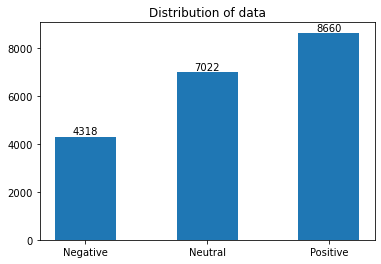

In [50]:
# ax = df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',legend=True)
values = [neg_count, neu_count,pos_count]
plt.bar(['Negative','Neutral', "Positive"],values, width=0.5)
plt.title("Distribution of data")
for i in range(3):
    plt.text(i, values[i], str(values[i]), ha='center', va='bottom')


Nhìn vào dữ liệu của biểu đồ cột chúng ta có thể thấy, 

5.3 Pie chart: So sánh tỉ lệ các tweets được gán nhãn

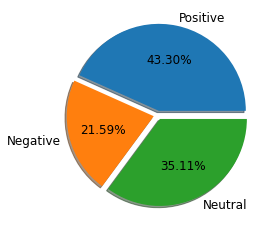

In [51]:
# Đếm xem có bao nhiêu nhãn cảm xúc trong tất cả các tweets
a=len(data[data["Sentiment"] == 1])
b=len(data[data["Sentiment"] == -1])
c=len(data[data["Sentiment"] == 0])
d=np.array([a,b,c])
explode = (0.05, 0.05, 0.05)
plt.pie(d,shadow=True,explode=explode,labels=["Positive","Negative","Neutral"],autopct='%1.2f%%', textprops={'fontsize': 12});


Dựa vào dữ liệu và những biểu đồ trực quan hóa, chúng ta có thể thấy những bình luận tích cực chiếm tỉ lệ lớn hơn trung tính và tiêu cực. Số lượng bình luận được phân loại là Positive chiếm tỉ lệ lớn hơn so với Neutral và Negative,chiếm tỉ lệ là 43.30%. Trong khi đó, số lượng bình luận phân loại Neutral chỉ chiếm 35,11% và Negative là 21,59%. Điều này có thể cho thấy rằng trong tập dữ liệu, người dùng Twitter có xu hướng tích cực hơn là tiêu cực hoặc trung tính.


**Từ đó chúng ta có thể đặt ra 1 số câu hỏi:**
1.	Tại sao tỉ lệ tweet tích cực lại cao hơn so với tweet tiêu cực và trung tính?  
      Điều này có thể do người dùng Twitter thường có xu hướng chia sẻ những trải nghiệm tích cực, bày tỏ cảm xúc tốt hoặc khen ngợi về sản phẩm, dịch vụ hoặc chủ đề đang được xét. Ngoài ra, có thể có những chiến lược marketing hoặc chiến dịch quảng cáo tích cực nhắm đến người dùng Twitter, làm cho tỉ lệ tweet tích cực tăng lên.
2.	Tại sao số lượng tweet trung tính lại chiếm tỉ lệ cao?  
  Số lượng tweet trung tính chiếm tỉ lệ cao có thể do một số người dùng Twitter không có cảm xúc rõ ràng về chủ đề đang được xét, hoặc không muốn chia  sẻ cảm xúc của mình. Ngoài ra, có thể có những tweet chỉ đơn giản là chia sẻ thông tin hoặc tin tức mà không mang tính chất cảm xúc cao.

3.	Tại sao cần quan tâm đến tweet tiêu cực?  
  Tweet tiêu cực có thể cho thấy các vấn đề hoặc thách thức đang tồn tại trong chủ đề đang được xét, hoặc cảm giác tiêu cực của người dùng về chủ đề đó. Việc phân tích các tweet tiêu cực này có thể giúp bạn hiểu rõ hơn về các vấn đề này và đưa ra các giải pháp hoặc cải thiện. Ngoài ra, tweet tiêu cực cũng có thể ảnh hưởng đến hình ảnh và uy tín của sản phẩm hoặc thương hiệu đang được xét, do đó cần được quan tâm và giải quyết kịp thời.


5.4: Plot a cloud of words for positive tweets

**Word cloud là một dạng trực quan hóa dữ liệu thường được sử dụng trong phân tích cảm xúc để đánh giá những từ khóa được sử dụng nhiều nhất trong dữ liệu**   
Những từ khóa có tần suất xuất hiện cao sẽ xuất hiện với kích thước lớn hơn.
Việc sử dụng word cloud giúp chúng ta nhanh chóng nhận ra các từ khóa quan trọng liên quan đến cảm xúc tích cực, giúp đưa ra các kết luận và hành động thích hợp. 

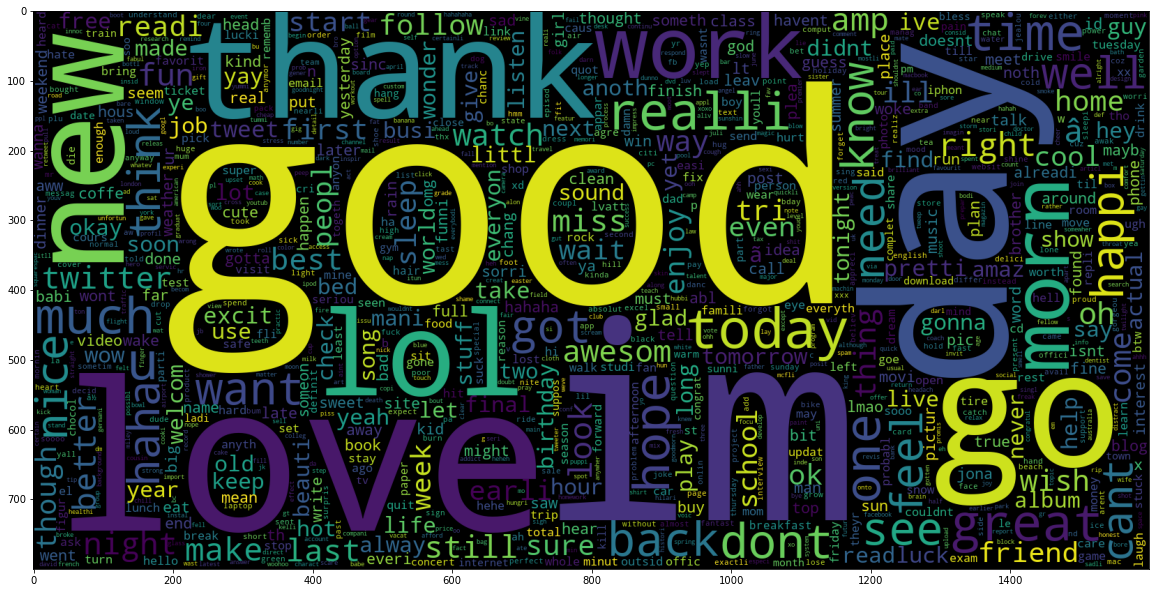

In [52]:
data_pos = (data[data['Sentiment'] == 1]["text"])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
# Tham số collocations: hiển thị các cụm từ phổ biến 
plt.imshow(wc)

Đoạn văn trên cho thấy những từ khóa phổ biến trong các tweet tích cực, bao gồm các từ mang tính từ và thán từ như "love", "good", "thank", "happy", "lol", "beautiful", "nice", "great", ...

Nhìn vào word cloud positive, ta có thể thấy rằng những từ này được sử dụng rất nhiều trong dữ liệu phân tích cảm xúc. Từ "love" và "good" đứng đầu với kích thước lớn nhất, đó là một từ khóa rất quan trọng trong phân tích cảm xúc tích cực, chứng tỏ người dùng rất yêu thích nội dung mà họ đang thảo luận. 


5.5: Plot a cloud of words for neutral tweets

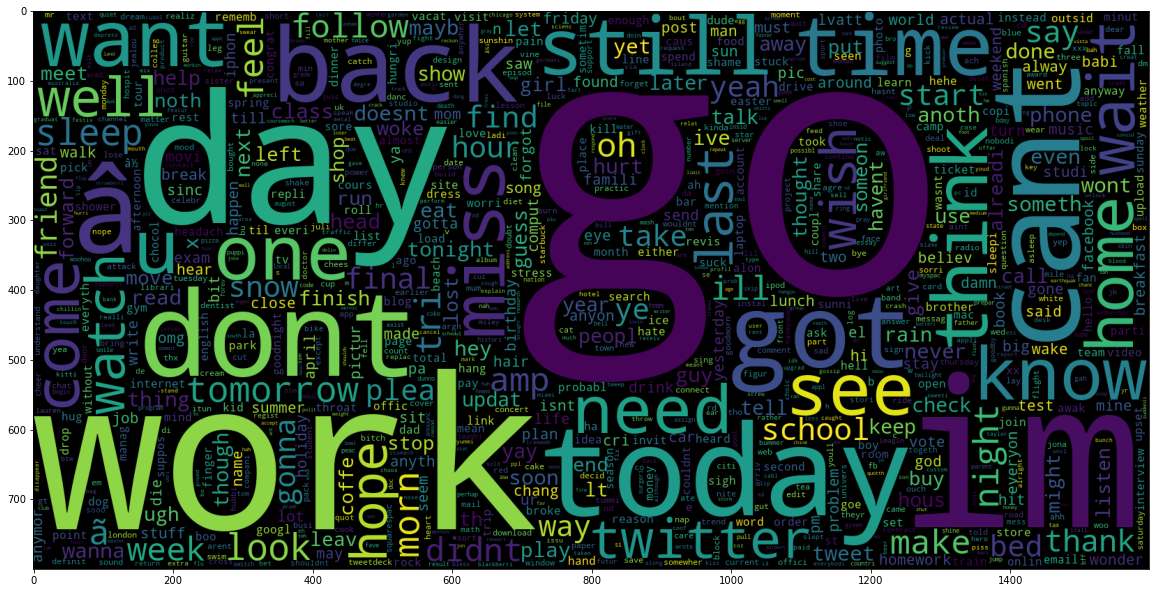

In [53]:
data_neu = (data[data['Sentiment'] == 0]["text"])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neu))
# Tham số collocations: hiển thị các cụm từ phổ biến 
plt.imshow(wc)

Trong trường hợp biểu đồ đám mây của những bình luận được phân loại là Neutral, chúng ta gặp khó khăn khi rút ra những kết luận từ các từ khóa nổi bật. Những từ như "go", "work", "im", "day", "today",... thường không mang nhiều ý nghĩa để phân loại thành tích cực hay tiêu cực.


5.6: Plot a cloud of words for negative tweets

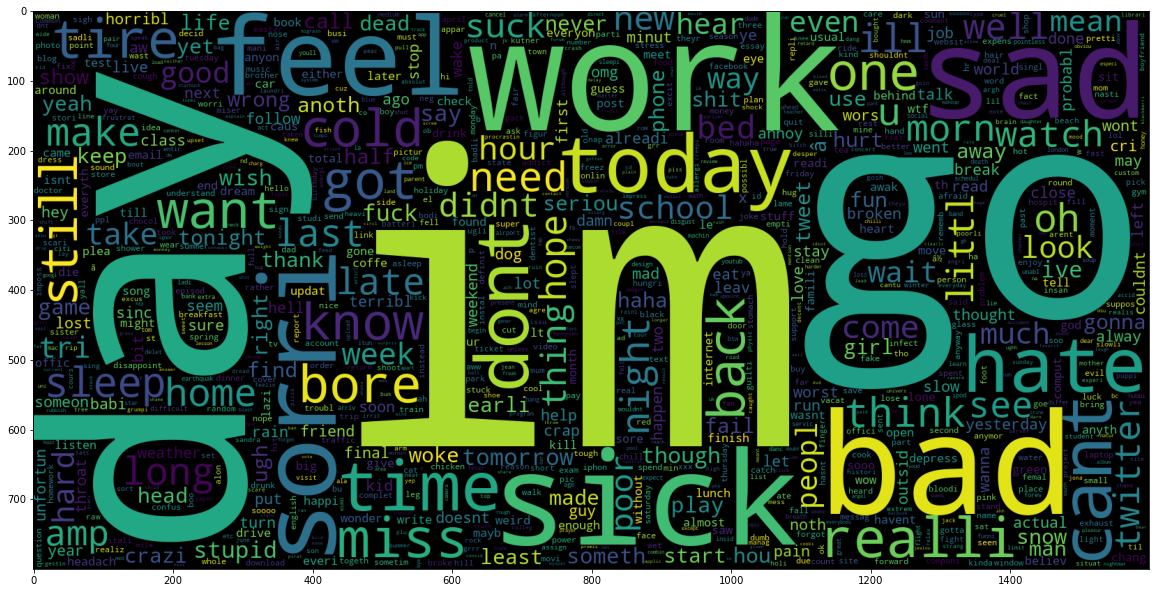

In [54]:
data_neg = (data[data['Sentiment'] == -1]["text"])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
# Tham số collocations: hiển thị các cụm từ phổ biến 
plt.imshow(wc)

**Một số từ khóa đặc trưng xuất hiện trong các bình luận tiêu cực: im, go, day, work, bad, hate, sad, cant, miss, ...**
 
Các từ khóa này cho thấy những cảm xúc tiêu cực thường gặp trong cuộc sống và sử dụng trong các bình luận của người dùng.  

 Các từ được xuất hiện nhiều và kích thước lớn trong biểu đồ đám mây được phân loại là Negative như “hate”, “bad”, “hate”, “sad”, “sorri”, “tired”, … thường mang cảm xúc, trạng thái của người dùng thể hiện tính tiêu cực cao.

# Splitting our data into Train and Test Subset

In [55]:
X=data.text
y=data.Sentiment
print(X, y)

0                  bummer shoulda got david carr third day
1        upset cant updat facebook text might cri resul...
2             dive mani time ball manag save rest go bound
3                          whole bodi feel itchi like fire
4                                    behav im mad cant see
                               ...                        
19995                           woke school best feel ever
19996         thewdbcom cool hear old walt interview ã â â
19997                         readi mojo makeov ask detail
19998    happi th birthday boo alll time tupac amaru sh...
19999                                 happi charitytuesday
Name: text, Length: 20000, dtype: object 0        1
1        0
2        1
3        1
4       -1
        ..
19995    1
19996    1
19997    1
19998    1
19999    1
Name: Sentiment, Length: 20000, dtype: int64


In [56]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =100)
print("Độ lớn tập X_train: ", len(X_train))
print("Độ lớn X_test: ", len(X_test))

Độ lớn tập X_train:  16000
Độ lớn X_test:  4000


# Transforming Dataset using TF-IDF Vectorizer

Transform the data using TF-IDF Vectorizer

In [57]:
#  Ma trận TF-IDF
vectoriser = TfidfVectorizer()         
vectoriser.fit_transform(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print('Số lượng từ được lấy làm thuộc tính trong ma trận TF-IDF: ', len(vectoriser.get_feature_names()))




Số lượng từ được lấy làm thuộc tính trong ma trận TF-IDF:  15590


# Model Building

Trong báo cáo vấn đề, tôi đã sử dụng ba mô hình khác nhau tương ứng :

1. Bernoulli Naive Bayes

2. SVM (Support Vector Machine)

3. Logistic Regression


8.1: Model-1

In [58]:
start = time.time()
# Tạo mô hình BernoulliNB
model = BernoulliNB()
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))
print("Thời gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 76.30%
Thời gian chạy:  0.015974044799804688
Báo cáo phân loại:
              precision    recall  f1-score   support

          -1       0.87      0.36      0.51       863
           0       0.79      0.82      0.80      1411
           1       0.73      0.92      0.81      1726

    accuracy                           0.76      4000
   macro avg       0.79      0.70      0.71      4000
weighted avg       0.78      0.76      0.74      4000



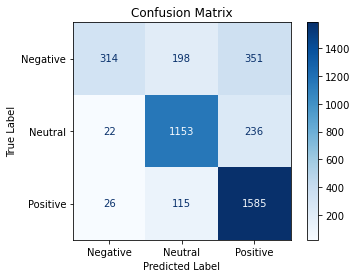

In [59]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Biểu diễn ma trận nhầm lẫn bằng ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Thiết lập tham số cho TfidfVectorizer giúp loại bỏ data thưa thớt, không mang lại nhiều ý nghĩa**


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =11)
vectoriser = TfidfVectorizer (max_features=5000, min_df=4)
vectoriser.fit_transform(X_train)
X_train = vectoriser.fit_transform(X_train)
X_test = vectoriser.transform(X_test)
print('Số feature_words: ', len(vectoriser.get_feature_names()))

Số feature_words:  3080


**Ta có thể thấy, độ chính xác vẫn còn thấp, thuật toán chạy chậm vì số lượng features quá lớn: 15590. Chúng ta có thể giảm số lượng features để thuật toán học nhanh hơn**.

- Thiết lập tham số max_features=5000 trong lúc tạo đối tượng TfidfVectorizer. Tuy nhiên cách này sẽ mất đi nhiều từ có ý nghĩa trong từ điển.
- Thiết lập tham số min_df=4 để loại bỏ những feature có số lượng từ tần suất xuất hiện ít hơn 4 lần.
  Số feature ban đầu 24810. Sau khi tối ưu, số feature là 3516.
  


Chạy lại model

In [61]:
start = time.time()
# Tạo mô hình BernoulliNB
model = BernoulliNB()
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))

print("Thời gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 81.50%
Thời gian chạy:  0.013005256652832031
Báo cáo phân loại:
              precision    recall  f1-score   support

          -1       0.78      0.67      0.72       862
           0       0.82      0.85      0.83      1394
           1       0.83      0.86      0.84      1744

    accuracy                           0.81      4000
   macro avg       0.81      0.79      0.80      4000
weighted avg       0.81      0.81      0.81      4000



  Chúng ta có thể loại bỏ đáng kể feature xuất hiện ít dẫn đến gây nhiễu dữ liệu. Độ chính xác thuật toán tăng từ 74.7% lên 82.55%.
Thời gian chạy thuật toán cũng nhanh hơn. Khác biệt khi chạy thuật toán với số lượng feature lớn và số lần chạy thuật toán lớn.

=> Không phải lúc nào dùng nhiều data để học cũng tốt.


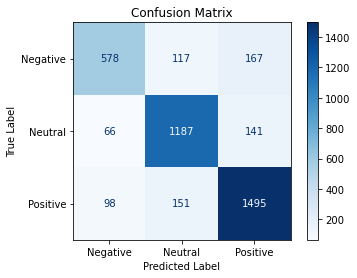

In [62]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Biểu diễn ma trận nhầm lẫn bằng ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

8.2: Model-2:

In [71]:
start = time.time()

# Tạo mô hình LinearSVC
model = LinearSVC(penalty="l2", loss="squared_hinge")
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))

print("Thơi gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 84.82%
Thơi gian chạy:  0.21941423416137695
Báo cáo phân loại:
              precision    recall  f1-score   support

          -1       0.84      0.74      0.79       862
           0       0.81      0.90      0.85      1394
           1       0.89      0.86      0.87      1744

    accuracy                           0.85      4000
   macro avg       0.85      0.83      0.84      4000
weighted avg       0.85      0.85      0.85      4000



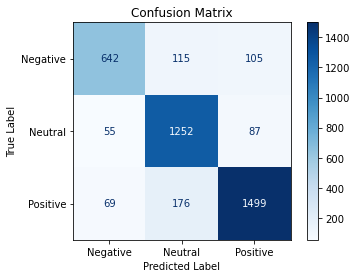

In [64]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Biểu diễn ma trận nhầm lẫn bằng ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

8.3. Model-3

In [72]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

# Tạo mô hình LinearSVC
model = RandomForestClassifier(n_estimators= 200, criterion="gini")
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))

print("Thời gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 85.65%
Thời gian chạy:  23.543042421340942
Báo cáo phân loại:
              precision    recall  f1-score   support

          -1       0.88      0.68      0.77       862
           0       0.83      0.93      0.87      1394
           1       0.88      0.89      0.88      1744

    accuracy                           0.86      4000
   macro avg       0.86      0.83      0.84      4000
weighted avg       0.86      0.86      0.85      4000



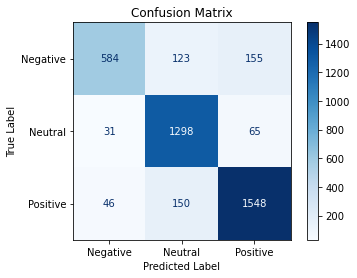

In [66]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Biểu diễn ma trận nhầm lẫn bằng ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()